# Binary Image Classification Deep Learning Model for [PROJECT NAME] Using TensorFlow Version 1
### David Lowe
### November 23, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The [PROJECT NAME] dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: [Sample Paragraph - The dataset contains 500 rendered images of various species of horses in different poses in multiple locations. It also includes 527 rendered images of humans in various poses and locations. Emphasis has been taken to ensure the diversity of humans, and to that end, there are both men and women as well as different ethnic groups present in the training set. The validation set adds six different figures of varying gender, race, and pose to ensure the breadth of data.]

ANALYSIS: [Sample Paragraph - The performance of the baseline model achieved an accuracy score of 94.35% after 20 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation dataset with an accuracy score of 98.52%. Furthermore, the final model processed the test dataset with an accuracy measurement of 73.80%.]

CONCLUSION: In this iteration, the TensorFlow CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Binary image classification with numerical attributes

Dataset Reference: [http://www.laurencemoroney.com/horses-or-humans-dataset/]

One potential source of performance benchmarks: [http://www.laurencemoroney.com/horses-or-humans-dataset/]

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# # Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# # Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# # Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [5]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


## 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
seedNum = 888

In [7]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import boto3
import zipfile
from datetime import datetime
from dotenv import load_dotenv
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set various default modeling parameters
default_loss = 'binary_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epoch = 20
default_batch = 32

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 0
TensorFlow version: 2.3.0


In [9]:
# Set up the parent directory location for loading the dotenv files
# useColab = True
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = True
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [12]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [13]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [14]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [15]:
!rm -rf image/
!rm horse-or-human-training.zip
!rm horse-or-human-validation.zip

rm: cannot remove 'horse-or-human-training.zip': No such file or directory
rm: cannot remove 'horse-or-human-validation.zip': No such file or directory


In [16]:
!mkdir images/
!mkdir images/training/
!mkdir images/validation/

In [17]:
!wget https://dainesanalytics.com/datasets/laurencemoroney-horses-humans-dataset/horse-or-human-training.zip

--2020-11-13 02:49:31--  https://dainesanalytics.com/datasets/laurencemoroney-horses-humans-dataset/horse-or-human-training.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.249.201.125, 13.249.201.72, 13.249.201.26, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.249.201.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human-training.zip’

horse-or-human-trai 100%[===================>] 142.65M  19.6MB/s    in 7.8s    

2020-11-13 02:49:39 (18.4 MB/s) - ‘horse-or-human-training.zip’ saved [149574867/149574867]



In [18]:
!wget https://dainesanalytics.com/datasets/laurencemoroney-horses-humans-dataset/horse-or-human-validation.zip

--2020-11-13 02:49:41--  https://dainesanalytics.com/datasets/laurencemoroney-horses-humans-dataset/horse-or-human-validation.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.224.42.127, 13.224.42.81, 13.224.42.40, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.224.42.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘horse-or-human-validation.zip’

horse-or-human-vali 100%[===================>]  10.95M  8.81MB/s    in 1.2s    

2020-11-13 02:49:43 (8.81 MB/s) - ‘horse-or-human-validation.zip’ saved [11480187/11480187]



In [19]:
local_zip = 'horse-or-human-training.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
train_dir = 'images/training/'
zip_ref.extractall(train_dir)
local_zip = 'horse-or-human-validation.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
validation_dir = 'images/validation/'
zip_ref.extractall(validation_dir)
zip_ref.close()

In [20]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Pre-process Data

In [31]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 3 - Pre-process Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [32]:
# Compose pipeline for the numerical and categorical features
numeric_columns = X_train_df.select_dtypes(include=['int','float']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', preprocessing.PowerTransformer())
])
categorical_columns = X_train_df.select_dtypes(include=['object','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the dataframe:", X_train_df.shape[1])

Number of numerical columns: 60
Number of categorical columns: 0
Total number of columns in the dataframe: 60


In [33]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
#     ('cat', categorical_transformer, categorical_columns)
])
X_train = preprocessor.fit_transform(X_train_df)
print("Transformed X_train.shape:", X_train.shape)

Transformed X_train.shape: (166, 60)


In [34]:
# # Apply binning techniques with continuous data (Block #1 of 1)
# discrete_feature = preprocessing.Binarizer(threshold=0.0)
# discrete_feature = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
# feature_binned = discrete_feature.fit_transform(X_original[['old_feature1']])
# X_train_df['new_feature1'] = feature_binned
# X_train_df['new_feature1'] = X_train_df['new_feature1'].astype('category')
# X_train_df.drop(columns=['old_feature1', 'old_feature2'], inplace=True)
# X_train_df.head()

### 3.b) Training Data Balancing

In [35]:
# Not applicable for this iteration of the project

In [36]:
# Examine the target classes for imbalanced distribution
# Xy_original.groupby('targetVar').size()

In [37]:
# # Perform SMOTE transformation on the training data (Block #1 of 2)
# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [38]:
# # Perform SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# over_sample = SMOTE(sampling_strategy=0.05, random_state=seedNum)
# under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=seedNum)
# steps = [('o', over_sample), ('u', under_sample)]
# sample_pipeline = Pipeline(steps=steps)
# X_train, y_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.c) Display the Final Datasets for Model-Building

In [39]:
# Finalize the training dataset for the modeling activities
class_encoder = preprocessing.LabelEncoder()
y_train = class_encoder.fit_transform(y_train_df)
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

X_train.shape: (166, 60) y_train.shape: (166,)


In [40]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 3 - Pre-process Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Train and Evaluate Models

In [41]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 4 - Train and Evaluate Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [42]:
# Define the default numbers of input/output for modeling
num_inputs = X_train.shape[1]
num_outputs = 1

In [43]:
# Define the baseline model for benchmarking
def create_nn_model(n_inputs=num_inputs, n_outputs=num_outputs, layer1_nodes=16, layer2_nodes=16, layer1_dropout=0, layer2_dropout=0, opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(n_inputs,), activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(n_outputs, activation='sigmoid', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model

In [44]:
# Initialize the default model and get a baseline result
startTimeModule = datetime.now()
results = list()
iteration = 0
reset_random(seedNum)
baseline_model = create_nn_model()
cv = RepeatedKFold(n_splits=n_folds, n_repeats=n_iterations, random_state=seedNum)
for train_ix, val_ix in cv.split(X_train):
    feature_train, feature_validation = X_train[train_ix], X_train[val_ix]
    target_train, target_validation = y_train[train_ix], y_train[val_ix]
    baseline_model.fit(feature_train, target_train, epochs=default_epoch, batch_size=default_batch, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Accuracy measurement from iteration %d >>> %.2f%%' % (iteration, model_metric*100))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model accuracy from all iterations: %.2f%% (%.2f%%)' % (validation_score*100, validation_variance*100))
print('Total time for model fitting and cross validating:', (datetime.now() - startTimeModule))

Accuracy measurement from iteration 1 >>> 64.71%
Accuracy measurement from iteration 2 >>> 84.85%
Accuracy measurement from iteration 3 >>> 93.94%
Accuracy measurement from iteration 4 >>> 100.00%
Accuracy measurement from iteration 5 >>> 100.00%
Accuracy measurement from iteration 6 >>> 100.00%
Accuracy measurement from iteration 7 >>> 100.00%
Accuracy measurement from iteration 8 >>> 100.00%
Accuracy measurement from iteration 9 >>> 100.00%
Accuracy measurement from iteration 10 >>> 100.00%
Average model accuracy from all iterations: 94.35% (10.92%)
Total time for model fitting and cross validating: 0:00:05.699479


In [45]:
# Initialize the grid parameters for layer nodes
startTimeModule = datetime.now()
nodes_grid = [(32, 32), (48, 48), (64, 64), (96, 96), (128, 128)]
l1_dropout, l2_dropout = (0, 0)

# Build dataframe for reporting model performance summary
nodes_performance = pd.DataFrame(columns=['model_name','validation_score','validation_variance','layer1_nodes','layer2_nodes','layer1_dropout','layer2_dropout'])

serial_number = 0
for param in nodes_grid:
    startTimeIteration = datetime.now()
    serial_number = serial_number + 1
    model_name = "Model_" + str(serial_number).zfill(3)
    l1_nodes, l2_nodes = param
    print('Processing model %s with Layer 1: %d and Layer 2: %d nodes' % (model_name, l1_nodes, l2_nodes))
    results = list()
    iteration = 0
    reset_random(seedNum)
    node_grid_model = create_nn_model(n_inputs=num_inputs,
                                     n_outputs=num_outputs,
                                     layer1_nodes=l1_nodes,
                                     layer2_nodes=l2_nodes,
                                     opt_param=default_optimizer,
                                     init_param=default_kernel_init)
    cv = RepeatedKFold(n_splits=n_folds, n_repeats=n_iterations, random_state=seedNum)
    for train_ix, val_ix in cv.split(X_train):
        feature_train, feature_validation = X_train[train_ix], X_train[val_ix]
        target_train, target_validation = y_train[train_ix], y_train[val_ix]
        node_grid_model.fit(feature_train, target_train, epochs=default_epoch, batch_size=default_batch, verbose=0)
        model_metric = node_grid_model.evaluate(feature_validation, target_validation, verbose=0)[1]
        iteration = iteration + 1
        print('Accuracy measurement from iteration %d >>> %.2f%%' % (iteration, model_metric))
        results.append(model_metric)
    validation_score = np.mean(results)
    validation_variance = np.std(results)
    print('Average model accuracy from all iterations: %.2f%% (%.2f%%)' % (validation_score*100, validation_variance*100))
    print('Total time for model fitting and cross validating:', (datetime.now() - startTimeIteration))
    print()
    nodes_performance = nodes_performance.append({'model_name': model_name, 'validation_score': validation_score, 'validation_variance': validation_variance, 'layer1_nodes': l1_nodes, 'layer2_nodes': l2_nodes, 'layer1_dropout': l1_dropout, 'layer2_dropout': l2_dropout}, ignore_index=True)

nodes_performance.set_index('model_name', inplace=True)
print('Total time for performing search of the best layer node parameters:', (datetime.now() - startTimeModule))

Processing model Model_001 with Layer 1: 32 and Layer 2: 32 nodes
Accuracy measurement from iteration 1 >>> 0.85%
Accuracy measurement from iteration 2 >>> 0.97%
Accuracy measurement from iteration 3 >>> 1.00%
Accuracy measurement from iteration 4 >>> 1.00%
Accuracy measurement from iteration 5 >>> 1.00%
Accuracy measurement from iteration 6 >>> 1.00%
Accuracy measurement from iteration 7 >>> 1.00%
Accuracy measurement from iteration 8 >>> 1.00%
Accuracy measurement from iteration 9 >>> 1.00%
Accuracy measurement from iteration 10 >>> 1.00%
Average model accuracy from all iterations: 98.23% (4.40%)
Total time for model fitting and cross validating: 0:00:05.828703

Processing model Model_002 with Layer 1: 48 and Layer 2: 48 nodes
Accuracy measurement from iteration 1 >>> 0.82%
Accuracy measurement from iteration 2 >>> 1.00%
Accuracy measurement from iteration 3 >>> 1.00%
Accuracy measurement from iteration 4 >>> 1.00%
Accuracy measurement from iteration 5 >>> 1.00%
Accuracy measurement 

In [46]:
# Display the model performance summary
nodes_performance.sort_values(by=['validation_score'], ascending=False).head()

,validation_score,validation_variance,layer1_nodes,layer2_nodes,layer1_dropout,layer2_dropout
model_name,,,,,,
Model_005,0.985294,0.044118,128,128,0,0
Model_002,0.982353,0.052941,48,48,0,0
Model_001,0.982264,0.044044,32,32,0,0
Model_003,0.979412,0.061765,64,64,0,0
Model_004,0.976471,0.070588,96,96,0,0


In [47]:
# Initialize the grid parameters for the dropout ratio
startTimeModule = datetime.now()
l1_nodes = 128
l2_nodes = 128
l1_dropout_grid = [0, 0.25, 0.5]
l2_dropout_grid = [0, 0.5]

# Build dataframe for reporting model performance summary
dropout_performance = pd.DataFrame(columns=['model_name','validation_score','validation_variance','layer1_nodes','layer2_nodes','layer1_dropout','layer2_dropout'])

serial_number = 0
for l1_dropout in l1_dropout_grid:
    for l2_dropout in l2_dropout_grid:
        startTimeIteration = datetime.now()
        serial_number = serial_number + 1
        model_name = "Model_" + str(serial_number).zfill(3)
        print('Processing model %s with Layer 1: %d and Layer 2: %d nodes and dropout parameters of Layer 1: %.2f and Layer 2: %.2f' % (model_name, l1_nodes, l2_nodes, l1_dropout, l2_dropout))
        results = list()
        iteration = 0
        reset_random(seedNum)
        dropout_grid_model = create_nn_model(n_inputs=num_inputs,
                                            n_outputs=num_outputs,
                                            layer1_nodes=l1_nodes,
                                            layer2_nodes=l2_nodes,
                                            layer1_dropout=l1_dropout,
                                            layer2_dropout=l2_dropout,
                                            opt_param=default_optimizer,
                                            init_param=default_kernel_init)
        cv = RepeatedKFold(n_splits=n_folds, n_repeats=n_iterations, random_state=seedNum)
        for train_ix, val_ix in cv.split(X_train):
            feature_train, feature_validation = X_train[train_ix], X_train[val_ix]
            target_train, target_validation = y_train[train_ix], y_train[val_ix]
            dropout_grid_model.fit(feature_train, target_train, epochs=default_epoch, batch_size=default_batch, verbose=0)
            model_metric = dropout_grid_model.evaluate(feature_validation, target_validation, verbose=0)[1]
            iteration = iteration + 1
            print('Accuracy measurement from iteration %d >>> %.2f%%' % (iteration, model_metric*100))
            results.append(model_metric)
        validation_score = np.mean(results)
        validation_variance = np.std(results)
        print('Average model accuracy from all iterations: %.2f%% (%.2f%%)' % (validation_score*100, validation_variance*100))
        print('Total time for model fitting and cross validating:', (datetime.now() - startTimeIteration))
        print()
        dropout_performance = dropout_performance.append({'model_name': model_name, 'validation_score': validation_score, 'validation_variance': validation_variance, 'layer1_nodes': l1_nodes, 'layer2_nodes': l2_nodes, 'layer1_dropout': l1_dropout, 'layer2_dropout': l2_dropout}, ignore_index=True)

dropout_performance.set_index('model_name', inplace=True)
print('Total time for performing grid-search of the best dropout parameters:', (datetime.now() - startTimeModule))

Processing model Model_001 with Layer 1: 128 and Layer 2: 128 nodes and dropout parameters of Layer 1: 0.00 and Layer 2: 0.00
Accuracy measurement from iteration 1 >>> 85.29%
Accuracy measurement from iteration 2 >>> 100.00%
Accuracy measurement from iteration 3 >>> 100.00%
Accuracy measurement from iteration 4 >>> 100.00%
Accuracy measurement from iteration 5 >>> 100.00%
Accuracy measurement from iteration 6 >>> 100.00%
Accuracy measurement from iteration 7 >>> 100.00%
Accuracy measurement from iteration 8 >>> 100.00%
Accuracy measurement from iteration 9 >>> 100.00%
Accuracy measurement from iteration 10 >>> 100.00%
Average model accuracy from all iterations: 98.53% (4.41%)
Total time for model fitting and cross validating: 0:00:05.680234

Processing model Model_002 with Layer 1: 128 and Layer 2: 128 nodes and dropout parameters of Layer 1: 0.00 and Layer 2: 0.50
Accuracy measurement from iteration 1 >>> 85.29%
Accuracy measurement from iteration 2 >>> 100.00%
Accuracy measurement fr

In [48]:
# Display the model performance summary
dropout_performance.sort_values(by=['validation_score'], ascending=False).head()

,validation_score,validation_variance,layer1_nodes,layer2_nodes,layer1_dropout,layer2_dropout
model_name,,,,,,
Model_001,0.985294,0.044118,128,128,0,0
Model_002,0.985294,0.044118,128,128,0,0.5
Model_003,0.985294,0.044118,128,128,0.25,0
Model_004,0.985294,0.044118,128,128,0.25,0.5
Model_005,0.985294,0.044118,128,128,0.5,0


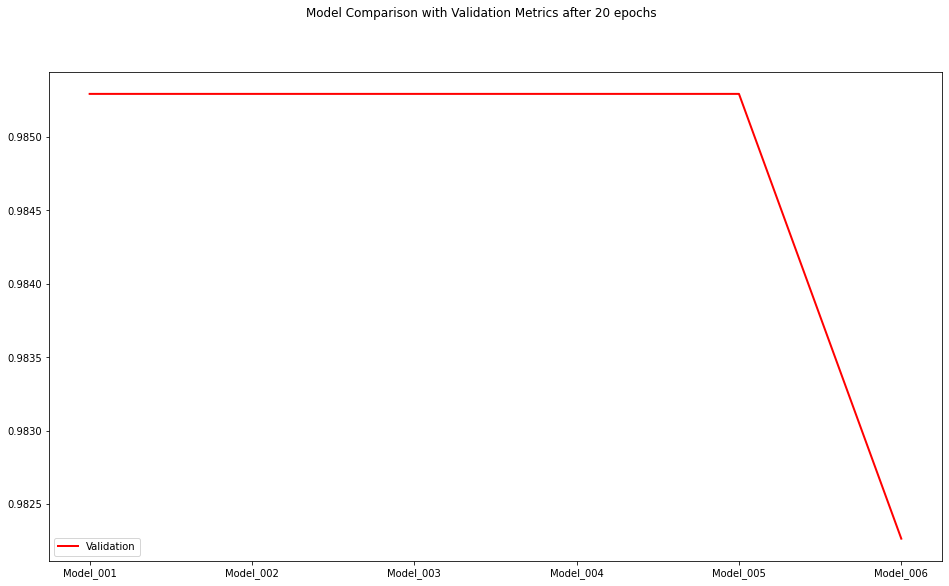

In [49]:
# Spot-checking the models
fig = plt.figure(figsize=(16,9))
title = 'Model Comparison with Validation Metrics after ' + str(default_epoch) + ' epochs'
fig.suptitle(title)
ax1 = fig.add_subplot(111)
ax1.plot(dropout_performance['validation_score'], color='r', lw=2.)
plt.legend(['Validation'], loc='lower left')
plt.show()

In [50]:
# Create the final model for evaluating the test dataset
model_to_use = 'Model_001'
final_l1_nodes = dropout_performance.loc[model_to_use]['layer1_nodes']
final_l2_nodes = dropout_performance.loc[model_to_use]['layer2_nodes']
final_l1_dropout = dropout_performance.loc[model_to_use]['layer1_dropout']
final_l2_dropout = dropout_performance.loc[model_to_use]['layer2_dropout']
final_optimizer = default_optimizer
final_kernel_init = default_kernel_init
final_epoch = default_epoch
final_batch = default_batch
print('Fitting final model with Layer 1: %d, Layer 2: %d with dropout parameters of Layer 1: %.2f, Layer 2: %.2f' % (final_l1_nodes, final_l2_nodes, final_l1_dropout, final_l2_dropout))
reset_random(seedNum)
final_model = create_nn_model(n_inputs=num_inputs,
                              n_outputs=num_outputs,
                              layer1_nodes=final_l1_nodes,
                              layer2_nodes=final_l2_nodes,
                              layer1_dropout=final_l1_dropout,
                              layer2_dropout=final_l2_dropout,
                              opt_param=final_optimizer,
                              init_param=final_kernel_init)
final_model.fit(X_train, y_train, epochs=final_epoch, batch_size=final_batch, verbose=1)

Fitting final model with Layer 1: 128, Layer 2: 128 with dropout parameters of Layer 1: 0.00, Layer 2: 0.00
Epoch 1/20
6/6 [==============================] - 0s 4ms/step - loss: 0.5949 - accuracy: 0.6747
Epoch 2/20
6/6 [==============================] - 0s 3ms/step - loss: 0.2772 - accuracy: 0.8735
Epoch 3/20
6/6 [==============================] - 0s 3ms/step - loss: 0.1653 - accuracy: 0.9518
Epoch 4/20
6/6 [==============================] - 0s 3ms/step - loss: 0.0969 - accuracy: 0.9518
Epoch 5/20
6/6 [==============================] - 0s 3ms/step - loss: 0.0545 - accuracy: 0.9819
Epoch 6/20
6/6 [==============================] - 0s 2ms/step - loss: 0.0240 - accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 0s 3ms/step - loss: 0.0141 - accuracy: 1.0000
Epoch 8/20
6/6 [==============================] - 0s 3ms/step - loss: 0.0087 - accuracy: 1.0000
Epoch 9/20
6/6 [==============================] - 0s 3ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 10/20
6/6 [===========

In [51]:
# Summarize the final model
final_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               7808      
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 129       
Total params: 24,449
Trainable params: 24,449
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Display the configuration details of the final model
final_model.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential_12", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 60], "dtype": "float32", "sparse": false, "ragged": false, "name": "dense_36_input"}}, {"class_name": "Dense", "config": {"name": "dense_36", "trainable": true, "batch_input_shape": [null, 60], "dtype": "float32", "units": 128, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": 888}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dropout", "config": {"name": "dropout_24", "trainable": true, "dtype": "float32", "rate": 0, "noise_shape": null, "seed": null}}, {"class_name": "Dense", "config": {"name": "dense_37", "trainable": true, "dtype": "float32", "units": 128, "activation": "relu", "use_bias": true, "kernel_initiali

In [53]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 4 - Train and Evaluate Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Present Analysis

In [54]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 5 - Finalize Model and Present Analysis has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [55]:
# Apply the same data preparation steps to the test dataset
X_test = preprocessor.transform(X_test_df)
# Encode the target variable
y_test = class_encoder.transform(y_test_df)
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (42, 60) y_test.shape: (42,)


In [56]:
# test_predictions = final_model.predict(X_test, batch_size=default_batch, verbose=1)
test_predictions = (final_model.predict(X_test) > 0.5).astype("int32").ravel()
print('Accuracy Score:', accuracy_score(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

Accuracy Score: 0.7380952380952381
[[18  4]
 [ 7 13]]
              precision    recall  f1-score   support

           0       0.72      0.82      0.77        22
           1       0.76      0.65      0.70        20

    accuracy                           0.74        42
   macro avg       0.74      0.73      0.73        42
weighted avg       0.74      0.74      0.74        42



In [57]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 5 - Finalize Model and Present Analysis completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [58]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:01:57.107268
